### If running within a Docker, no action is needed. If not, add the installation path (e.g. 'path_to_fwi2d_directory/local/bin') to the environment variables 'PATH' and 'PYTHONPATH' before running the notebook.

In [1]:
import numpy as np
import math
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib import rcParams

import seppy

sep = seppy.sep()

# Create a directory to store data
!mkdir -p data
datapath = "./data/"

### Generate source time function (Ricker wavelet)

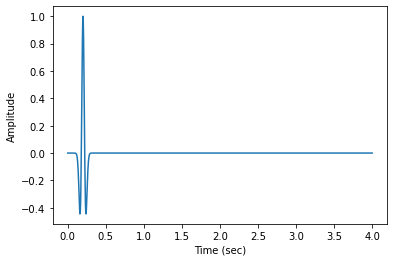

In [2]:
# source time function parameters
nt=1001 # number of time samples
dt=0.004 # sampling rate (sec)
ot=0.0 # origin time
f0=10. # peak frequency (Hz)
shift=50 # shift wavelet (number of samples)

# source wavelet
w=np.zeros(nt)
pi = math.pi
tshift=shift*dt
sig=math.sqrt(2)/(2*f0*pi)
t=np.linspace(0,(nt-1)*dt,nt)
w=(1.0 - ((t-tshift)/sig)**2)*np.exp( -0.5*((t-tshift)/sig)**2)

plt.plot(np.linspace(ot,(nt-1)*dt,nt),w)
plt.xlabel("Time (sec)")
plt.ylabel("Amplitude")
plt.show()

### Generate acoustic models

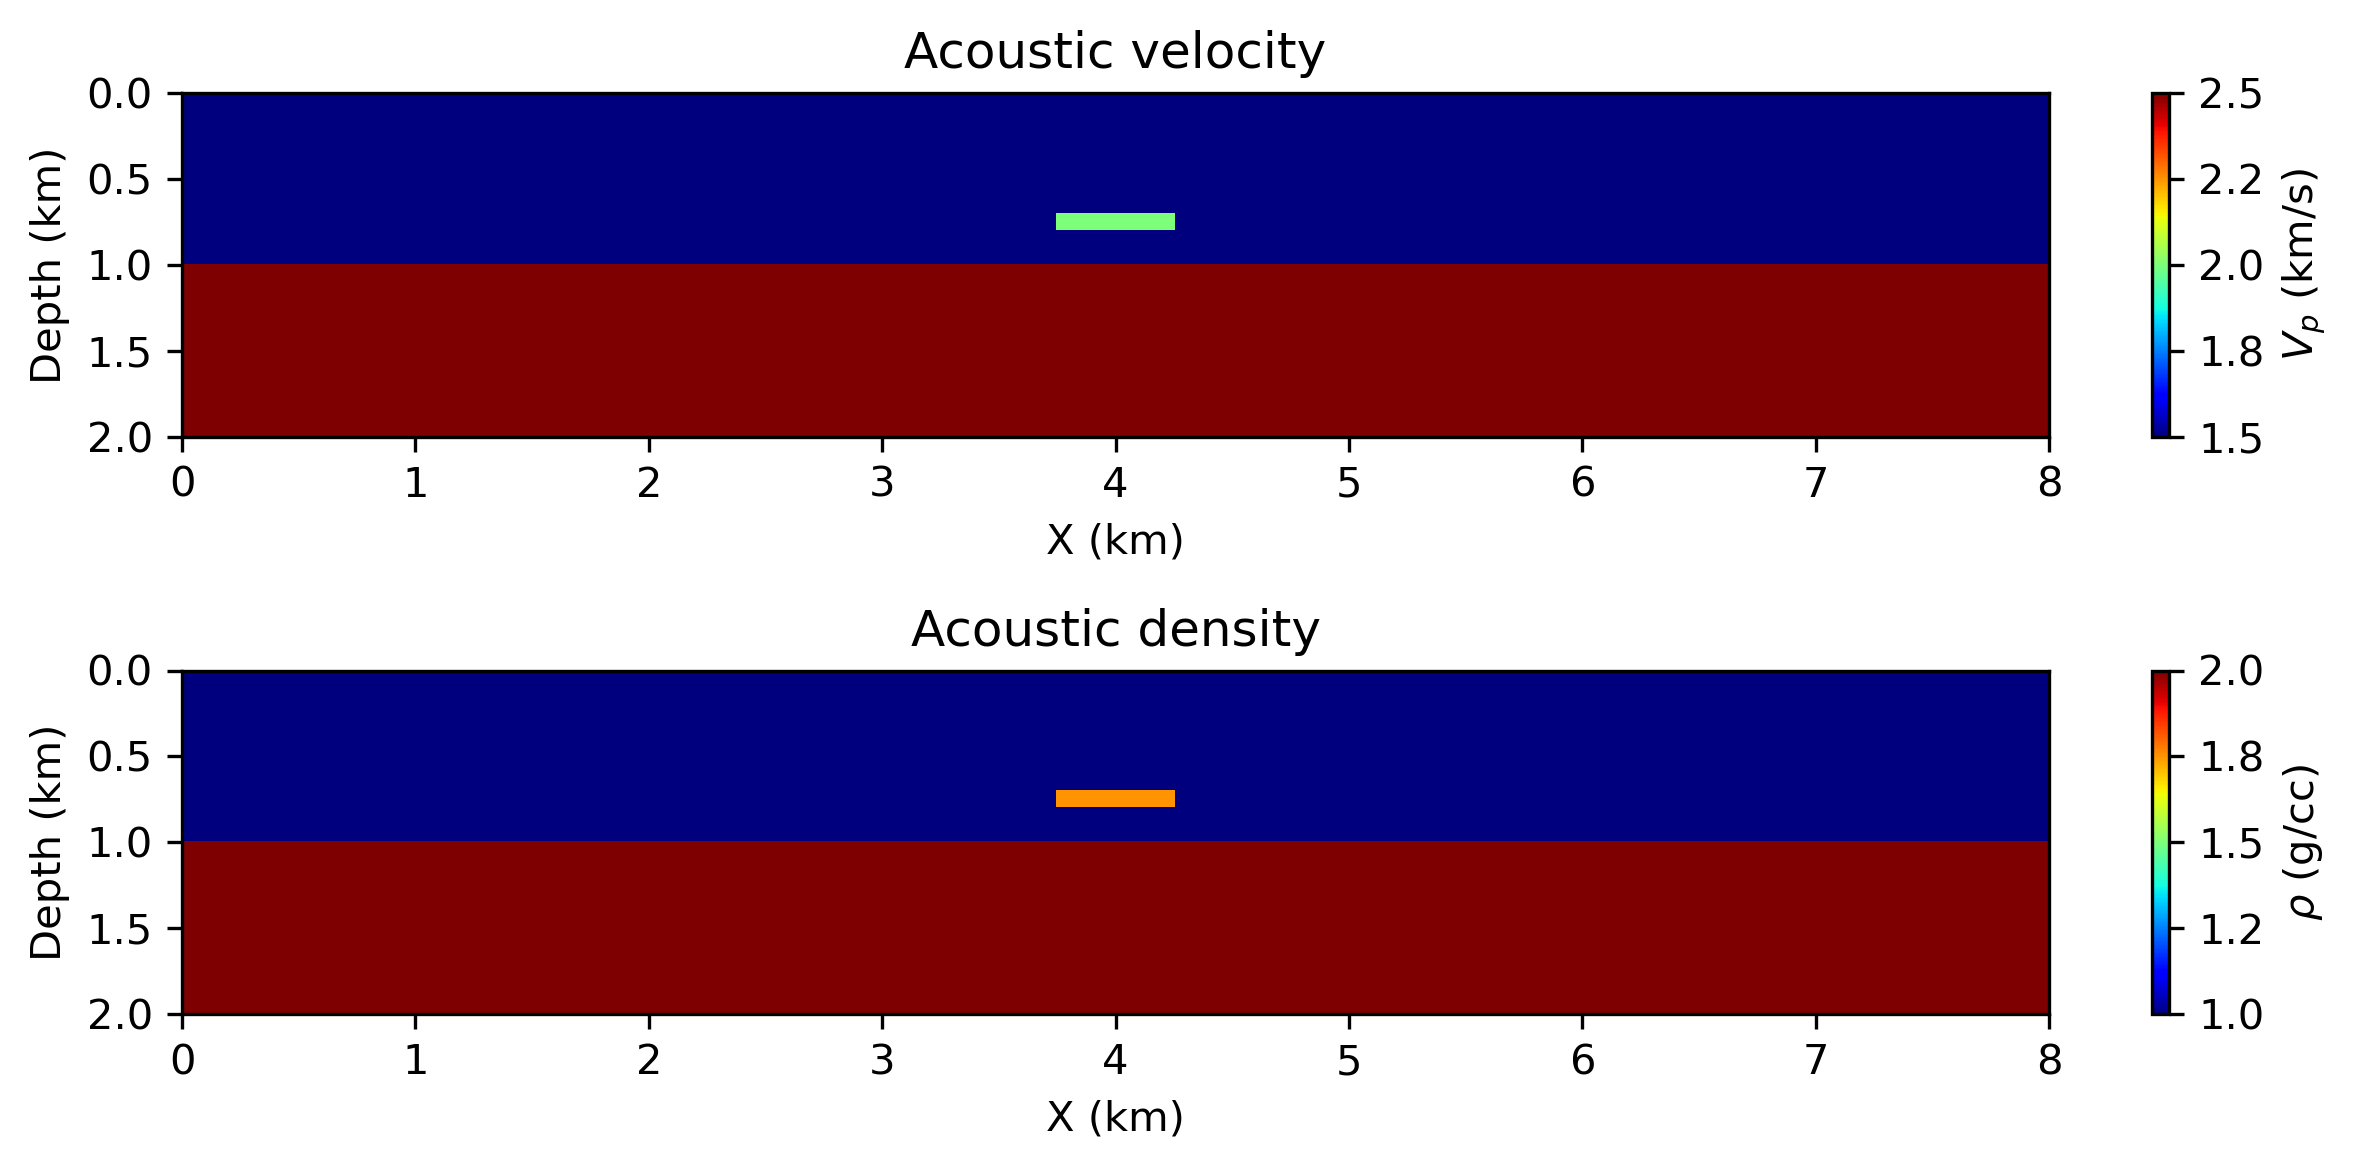

In [3]:
nz=201
nx=801
dz=0.01
dx=0.01
oz=0.0
ox=0.0
extent = [ox,ox+(nx-1)*dx,oz+(nz-1)*dz,oz]

# two-layers model (starting model)
model0=np.zeros((2,nx,nz))
model0[0,:,:100] = 1.5 # Vp in km/s
model0[0,:,100:] = 2.5
model0[1,:,:100] = 1.0 # Density in g/cc
model0[1,:,100:] = 2.0 # Density in g/cc

# true model = starting model + intrusion
model = np.copy(model0)
model[0,375:426,70:80] = 2.0
model[1,375:426,70:80] = 1.75

plt.figure(figsize=(8,4),dpi=300)
plt.subplot(2,1,1)
plt.imshow(np.transpose(model[0,:,:]),interpolation='none',aspect="auto",extent=extent,cmap='jet',vmin=1.5,vmax=2.5)
plt.xlabel('X (km)')
plt.ylabel('Depth (km)')
plt.colorbar(fraction=0.04, format='%.'+str(1)+'f',label=r'$V_p$ (km/s)')
plt.title("Acoustic velocity")

plt.subplot(2,1,2)
plt.imshow(np.transpose(model[1,:,:]),interpolation='none',aspect="auto",extent=extent,cmap='jet',vmin=1.0,vmax=2.0)
plt.xlabel('X (km)')
plt.ylabel('Depth (km)')
plt.colorbar(fraction=0.04, format='%.'+str(1)+'f',label=r'$\rho$ (g/cc)')
plt.title("Acoustic density")

plt.tight_layout()

In [4]:
# save wavelet and models to SEPlib
sep.write_file(datapath+"wavelet.H", w, ds=np.array([dt]), os=np.array([ot]), dpath=datapath)
sep.write_file(datapath+"model0.H", np.transpose(model0), ds=np.array([dz,dx,1]), os=np.array([oz,ox,0]), dpath=datapath)
sep.write_file(datapath+"model.H", np.transpose(model), ds=np.array([dz,dx,1]), os=np.array([oz,ox,0]), dpath=datapath)

### Generate true data and run FWI

In [5]:
# generate true data
!WE_MODELING.x source=./data/wavelet.H model=./data/model.H output=./data/data.H datapath=${PWD}/data/ \
verbose=0 fmax=30 dt=-1 \
ns=10 sx0=2 sz0=0.1 sxinc=0.4 nr=401 rx0=2 rz0=0.1 rxinc=0.01 \
bc_top=1 bc_bottom=2 bc_left=2 bc_right=2 taper_top=0 taper_bottom=50 taper_left=50 taper_right=50 taper_strength=0.08

--------------------------------------------------------------------------
[[23022,1],0]: A high-performance Open MPI point-to-point messaging module
was unable to find any relevant network interfaces:

Module: OpenFabrics (openib)
  Host: thanos

Another transport will be used instead, although this may result in
lower performance.

NOTE: You can disable this warning by setting the MCA parameter
btl_base_warn_component_unused to 0.
--------------------------------------------------------------------------

Size of MPI communicator = 1 ; current rank = 0


In [6]:
# load, and plot
ns=10 # number of shots
axes_data, data = sep.read_file(datapath+"data.H")
data = data.reshape([axes_data.n[0],int(axes_data.n[1]/ns),ns],order='F').T

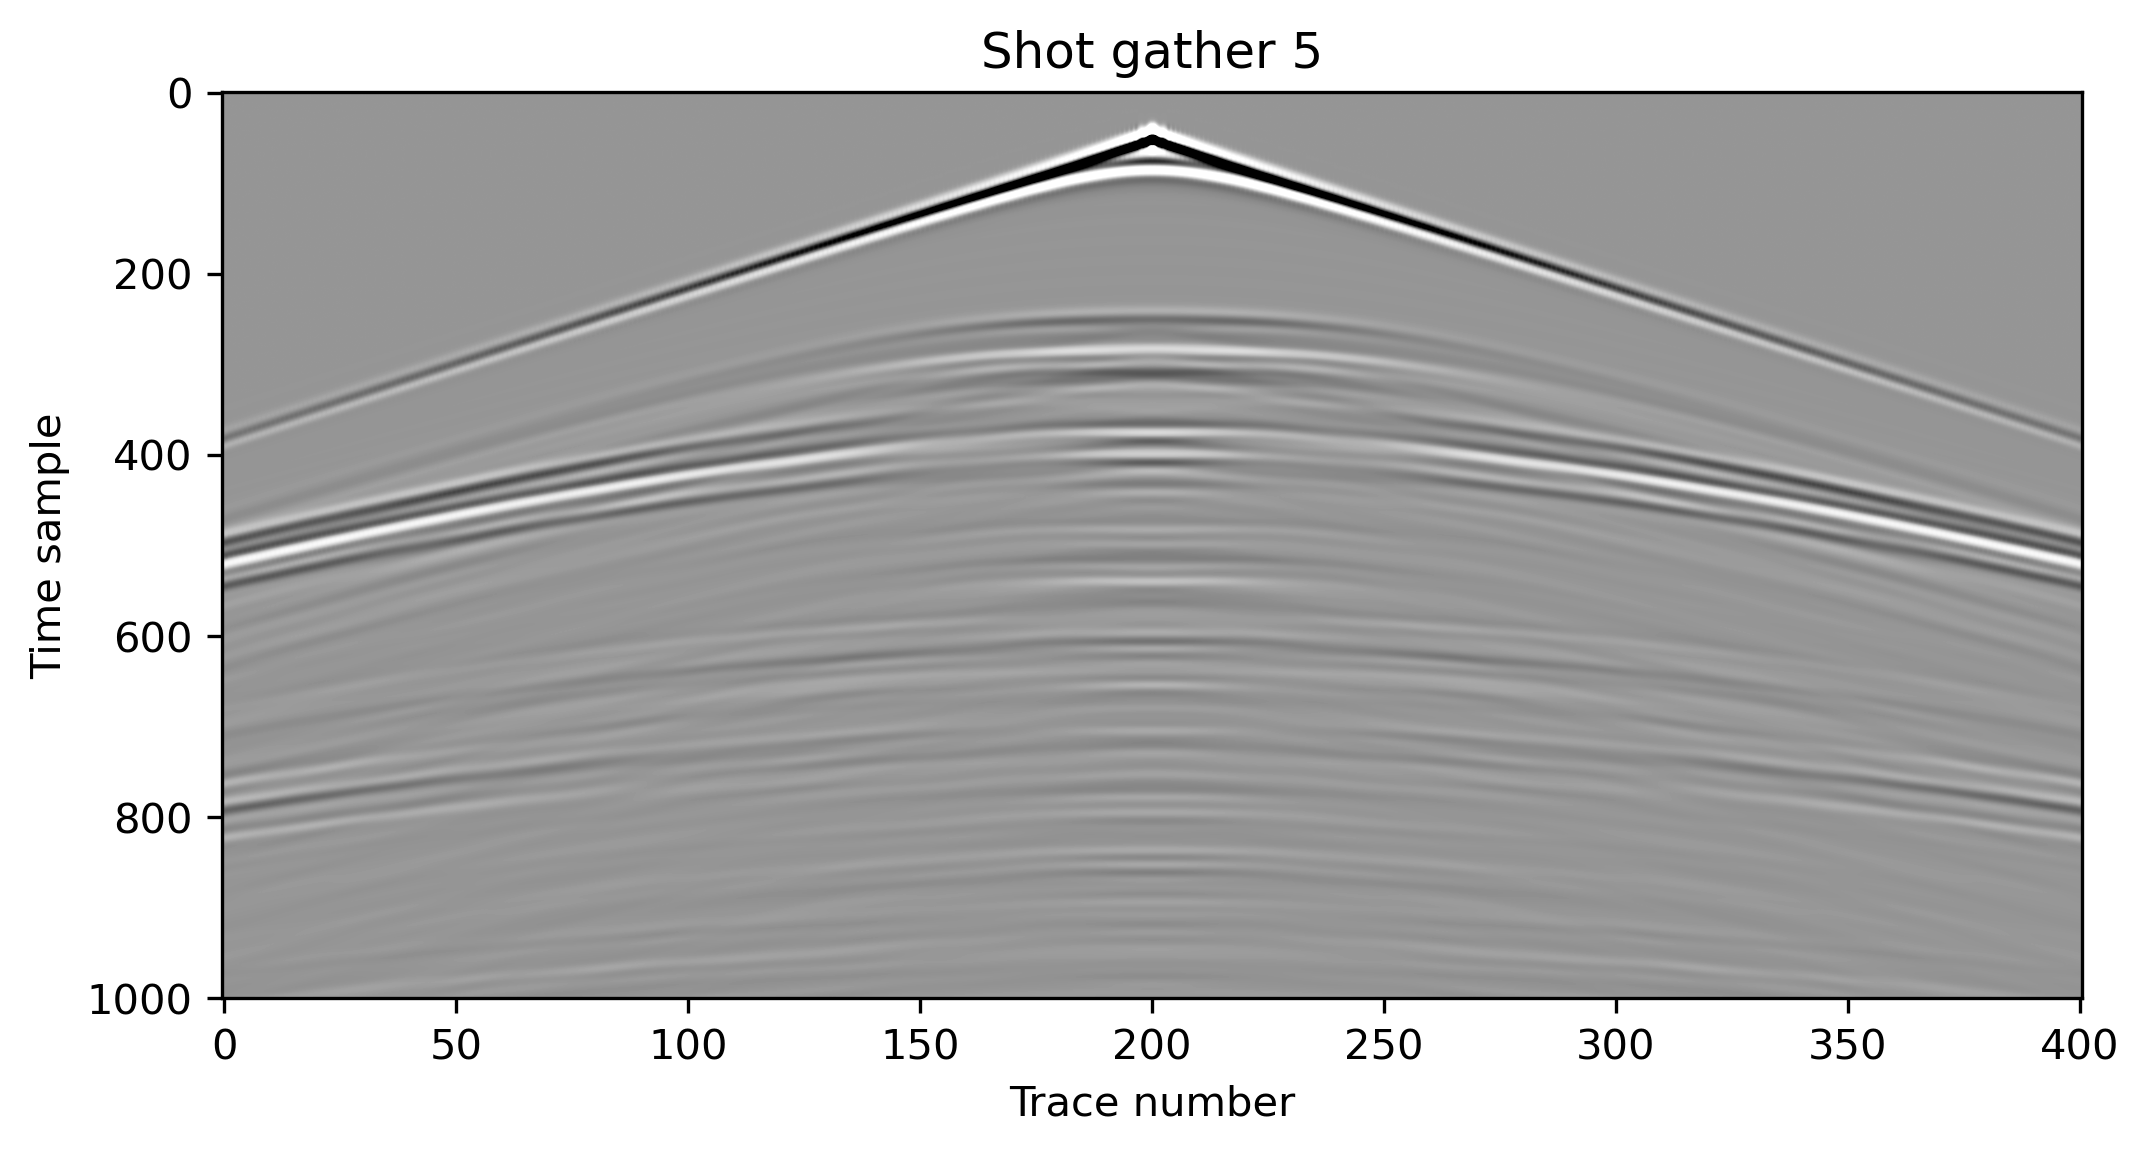

In [7]:
s=5
d=data[s]
vmax=np.amax(d)
p=0.1

plt.figure(figsize=(8,4),dpi=300)
plt.imshow(np.transpose(d),interpolation='sinc',aspect="auto",cmap='Greys',vmax=p*vmax,vmin=-p*vmax)
plt.xlabel('Trace number')
plt.ylabel('Time sample')
plt.title("Shot gather %s" %s)

plt.show()

In [8]:
# run FWI
!FWI2D.x source=./data/wavelet.H model=./data/model0.H data=./data/data.H output=./data/fwi.H datapath=${PWD}/data/ parfile=./par/acoustic_fwi.p

--------------------------------------------------------------------------
[[22892,1],0]: A high-performance Open MPI point-to-point messaging module
was unable to find any relevant network interfaces:

Module: OpenFabrics (openib)
  Host: thanos

Another transport will be used instead, although this may result in
lower performance.

NOTE: You can disable this warning by setting the MCA parameter
btl_base_warn_component_unused to 0.
--------------------------------------------------------------------------

Size of MPI communicator = 1 ; current rank = 0

Thu Oct 19 20:30:11 2023


 Subsurface model geometry
xmin=0.00000 km, xmax=8.00000 km, dx=0.01000 km, nx=801
zmin=0.00000 km, zmax=2.00000 km, dz=0.01000 km, nz=201

 Boundary conditions
Top boundary condition = free surface	 taper size = 0	 taper type = none
Bottom boundary condition = locally absorbing	 taper size = 50	 taper type = cosine squared
Left boundary condition = locally absorbing	 taper size = 50	 taper type = cosine squ

In [9]:
# load FWI model and plot
axes, fwi = sep.read_file(datapath+"fwi.H")
fwi = fwi.reshape(axes.n,order='F').T

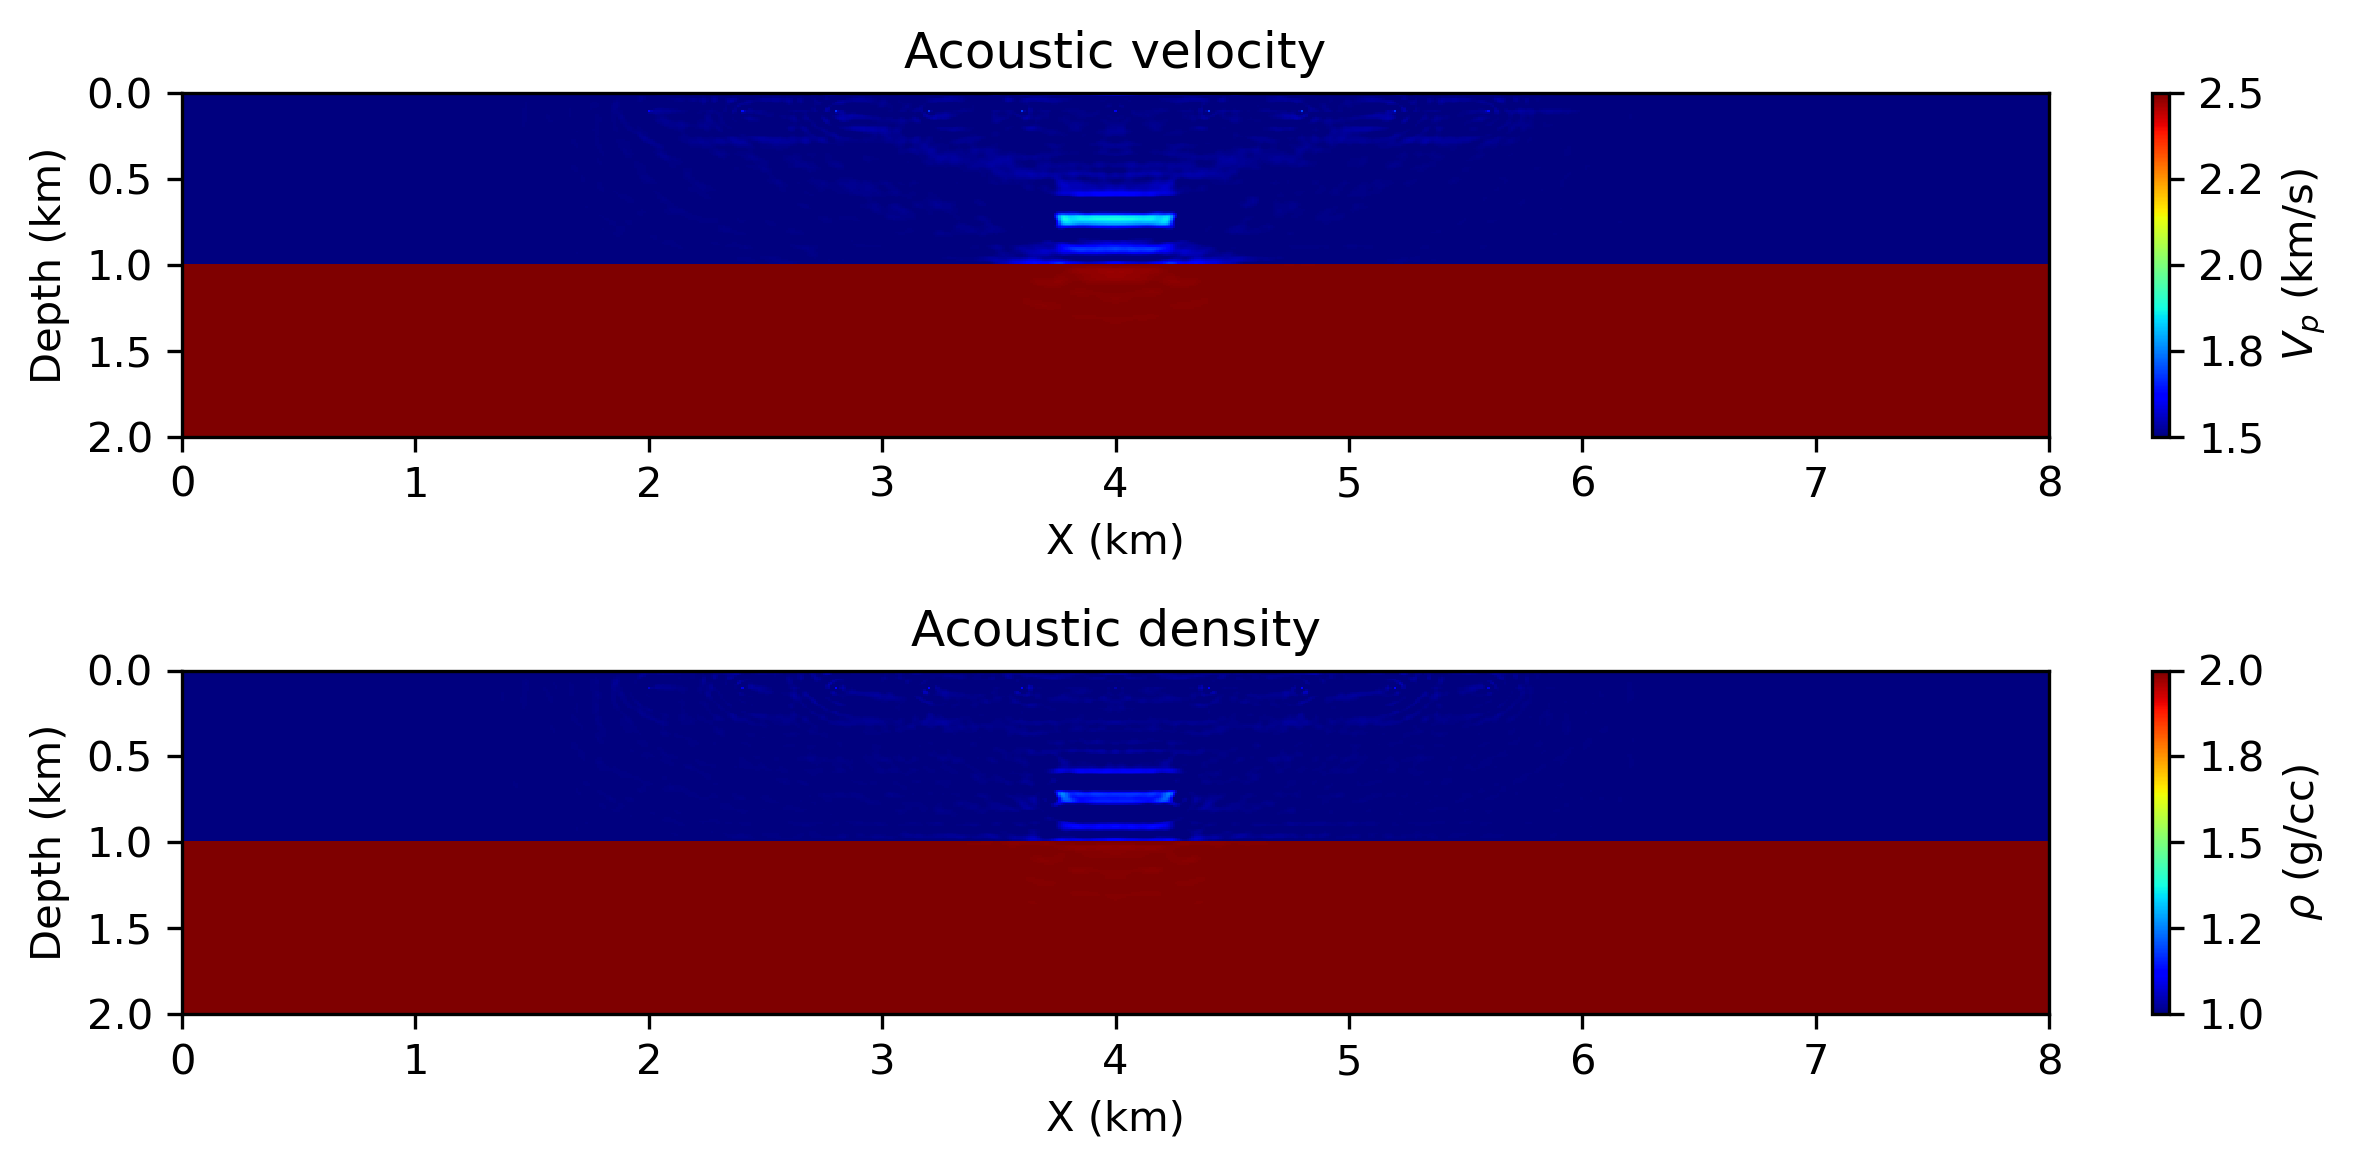

In [10]:
plt.figure(figsize=(8,4),dpi=300)
plt.subplot(2,1,1)
plt.imshow(np.transpose(fwi[0,:,:]),interpolation='none',aspect="auto",extent=extent,cmap='jet',vmin=1.5,vmax=2.5)
plt.xlabel('X (km)')
plt.ylabel('Depth (km)')
plt.colorbar(fraction=0.04, format='%.'+str(1)+'f',label=r'$V_p$ (km/s)')
plt.title("Acoustic velocity")

plt.subplot(2,1,2)
plt.imshow(np.transpose(fwi[1,:,:]),interpolation='none',aspect="auto",extent=extent,cmap='jet',vmin=1.0,vmax=2.0)
plt.xlabel('X (km)')
plt.ylabel('Depth (km)')
plt.colorbar(fraction=0.04, format='%.'+str(1)+'f',label=r'$\rho$ (g/cc)')
plt.title("Acoustic density")

plt.tight_layout()

Clean up the data directory

In [11]:
!rm -rf data